# Reference
All of this is from [here](https://www.overleaf.com/read/sndwwjwxfhpy)

In [135]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# Parameters

In [136]:
# Uncompensated quality factor
Q = 0.703

# Resonant frequency of the driver in a box
fsc = 31

# The moving mass and air load
m = 0.0424

In [137]:
# Calculate some other variables

# The spring constant
ks = m*((2*np.pi*fsc)**2)

# The damping constant
kf = np.sqrt(ks*m) / Q
ks, kf

(1608.6033950741894, 11.747679612740892)

Total Data Length: 239616 , Sample Rate: 48000


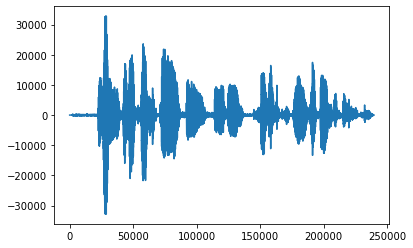

In [138]:
# Get the original data

sample_rate, input_data = wavfile.read('./samples/test.wav')
print("Total Data Length:", len(input_data), ", Sample Rate:",sample_rate)

num_seconds = 10

# Use this for sample data

# input_data = [0,1,2,3,1,2,3,0]
# sample_rate = 80
# num_seconds = 0.1

beg = 0
end = beg + int(sample_rate * num_seconds)

if (end > len(input_data)):
    end = len(input_data)

input_data = input_data[beg:end]

wavfile.write("original_sound.wav", sample_rate, input_data)

plt.plot(input_data)

In [139]:
def butterworth(arr, order=6, frequency=10, filter_type="highpass"):
#     print(order, frequency, filter_type)
    sos = signal.butter(order,frequency,filter_type,fs=sample_rate, output="sos")
    
    return signal.sosfilt(sos, arr)

def normalize(input_data, output_data):
    max_original = np.amax(np.absolute(input_data))
    max_values = np.amax(np.absolute(output_data))
    scalar = (max_original / max_values)
    print("Scalar:", scalar)
    
    for i in range(len(output_data)):
        output_data[i] = scalar * output_data[i]

    return output_data

In [140]:


# NOTE: this should not be beg, as input_data has been adjusted to include only the select values
time = 0
length = end - beg

first_integral = 0
second_integral = 0

Vis = butterworth(input_data, order=4, frequency=120, filter_type="lowpass")
wavfile.write("post_lowpass.wav", sample_rate, Vis)

Vfs = []
Vss = []

first_integrals = []
second_integrals = [] # this is really the integral of the butterworth_first_integrals

while time<length:
    first_integrals.append(first_integral)
    first_integral += Vis[time]
    time += 1

butterworth_first_integrals = butterworth(first_integrals, 6, 10, "highpass")

time = 0

while time<length:
    Vfs.append((kf/m) * butterworth_first_integrals[time])
    time += 1
    
time = 0

while time<length:
    second_integrals.append(second_integral)
    second_integral += butterworth_first_integrals[time]
    time += 1

butterworth_second_integrals = butterworth(second_integrals, 6, 10, "highpass")
    
time = 0

while time<length:
    Vss.append((ks/m) * butterworth_second_integrals[time])
    time += 1
    
Vos = normalize(input_data, butterworth(input_data, order=4, frequency=120, filter_type="highpass") - Vfs - Vss)
# Vos = butterworth(input_data, order=4, frequency=120, filter_type="highpass") - Vfs - Vss

Scalar: 2.0673860443749208e-08


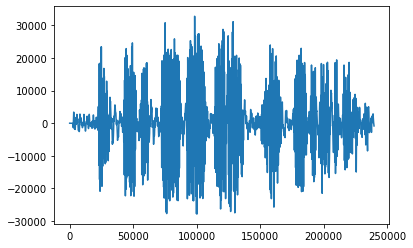

In [141]:
plt.plot(Vos)

In [142]:
wavfile.write("output.wav", sample_rate, Vos)